In [20]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
import networkx as nx
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

[(0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (0, 5), (1, 5), (2, 5), (0, 6), (1, 6), (2, 6)]


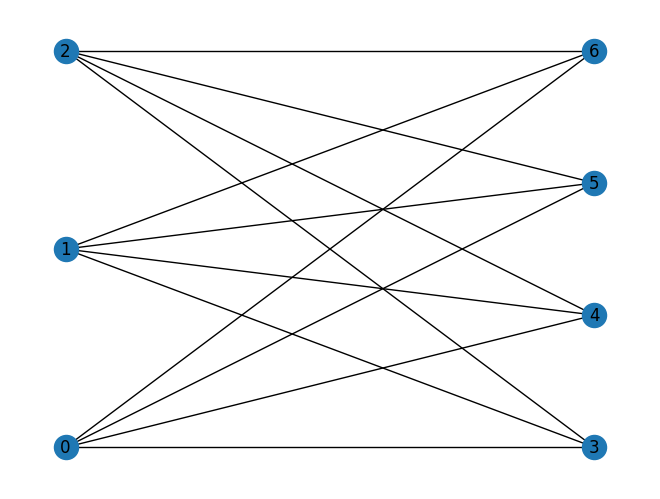

In [21]:
G = nx.Graph()
edges = []

n = 3
m = 4
for j in range(n,m + n):
    for i in range(n):
        edges.append((i, j))

gList = []

for i in range(n):
    gList.append(i)

print(edges)

G.add_edges_from(edges)
nx.draw(G,pos=nx.bipartite_layout(G, gList), with_labels=True)

In [22]:

pauli = []
def createSmp():
    smp = []
    for i in range(n + m):
        smp.append("I")
    return smp

for i in edges:
    smp = createSmp()
    for j in range(len(smp)):
        if j == i[0]:
            smp[j] = 'Z'
        if j == i[1]:
            smp[j] = 'Z'
    smp = smp[::-1]
    word = ''.join(smp)
    pauli.append(word)    

print(pauli)
print(edges)

pauliList = []

for i in range(len(pauli)):
    pauliList.append((pauli[i], 1))

print(pauliList)

['IIIZIIZ', 'IIIZIZI', 'IIIZZII', 'IIZIIIZ', 'IIZIIZI', 'IIZIZII', 'IZIIIIZ', 'IZIIIZI', 'IZIIZII', 'ZIIIIIZ', 'ZIIIIZI', 'ZIIIZII']
[(0, 3), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (0, 5), (1, 5), (2, 5), (0, 6), (1, 6), (2, 6)]
[('IIIZIIZ', 1), ('IIIZIZI', 1), ('IIIZZII', 1), ('IIZIIIZ', 1), ('IIZIIZI', 1), ('IIZIZII', 1), ('IZIIIIZ', 1), ('IZIIIZI', 1), ('IZIIZII', 1), ('ZIIIIIZ', 1), ('ZIIIIZI', 1), ('ZIIIZII', 1)]


In [ ]:
hamiltonian = SparsePauliOp.from_list(pauliList)

ansatz = QAOAAnsatz(hamiltonian, reps = 1)

ansatz.decompose(reps=1).draw(output='mpl')

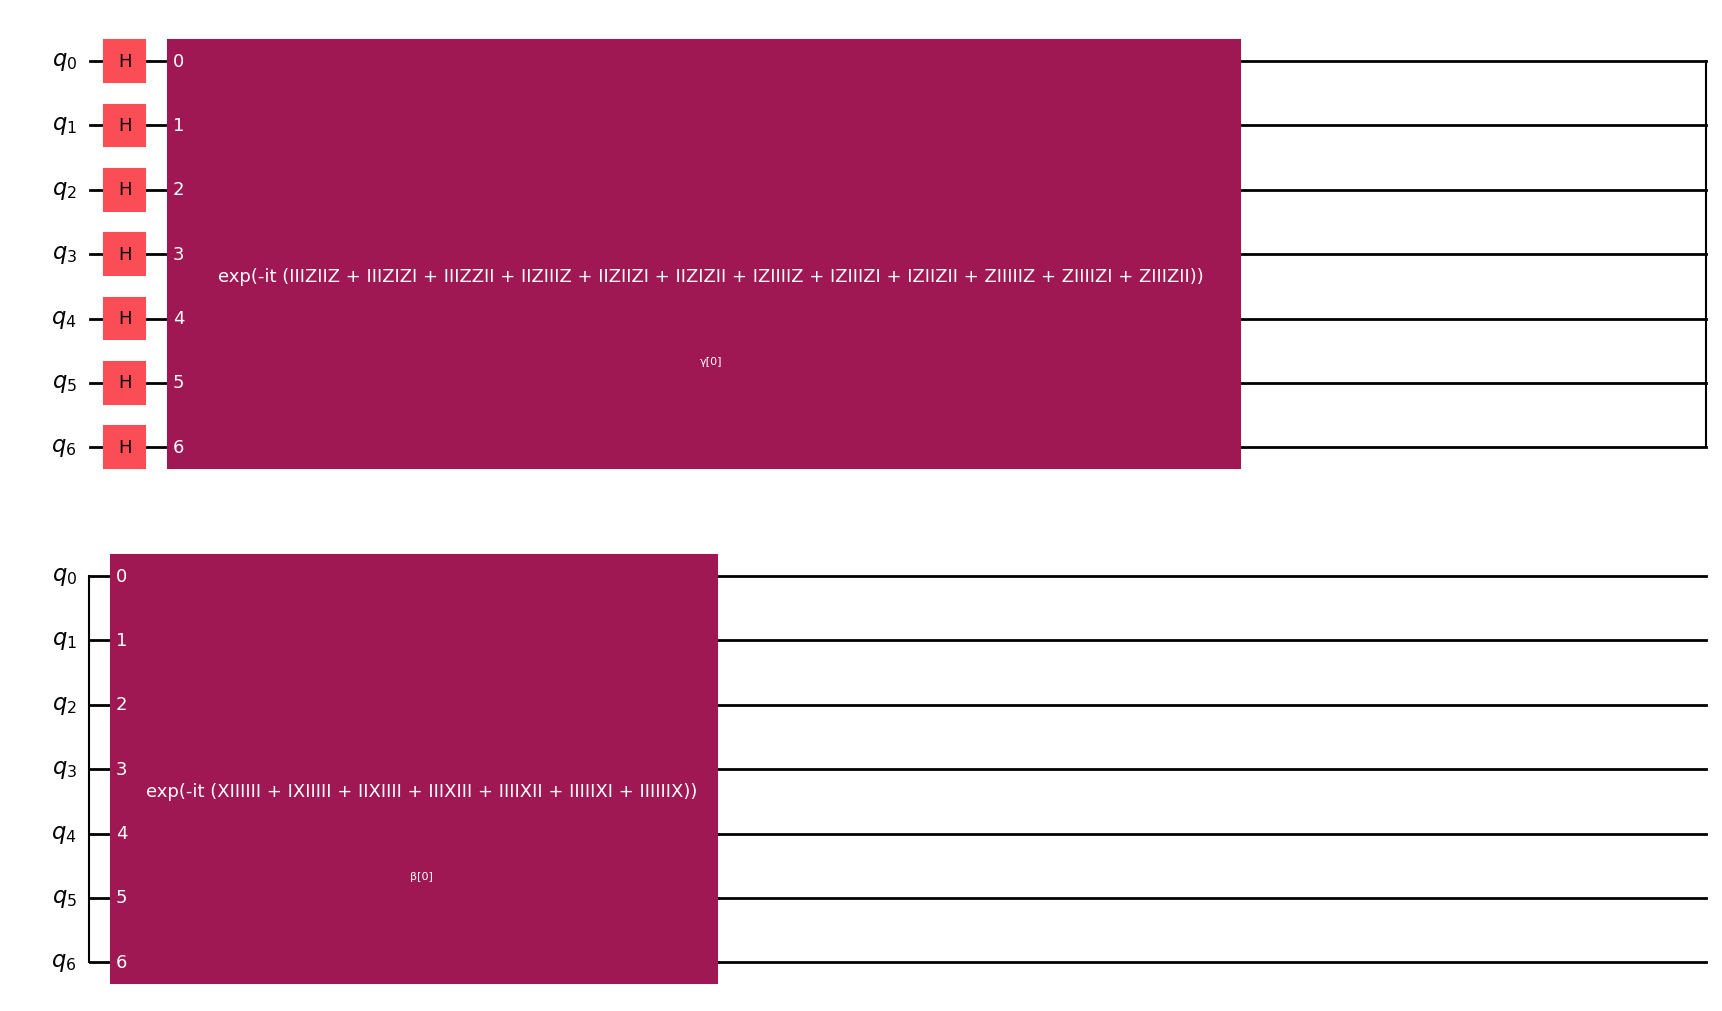

In [32]:
ansatz.decompose().draw(output='mpl')

In [70]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# 


# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')

In [71]:

# backend = service.least_busy(operational=True, simulator=False)
# backend.name

In [72]:
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# 
# 
# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=3)
# 
# ansatz_isa = pm.run(ansatz)

In [73]:
# ansatz_isa.draw(output="mpl", idle_wires=False)

In [74]:
# hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
# hamiltonian_isa

In [75]:
def cost_func(params, ansatz, hamiltonian, estimator):
    
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [127]:
# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
# session = Session(backend=backend)

from qiskit.primitives import (
    Sampler,
    StatevectorSampler,
    Estimator,
    StatevectorEstimator,
)

# Configure estimator
estimator = StatevectorEstimator()
# estimator.options.default_shots = 10_000
# estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler()
# sampler.options.default_shots = 10_000
# sampler.options.dynamical_decoupling.enable = True

In [128]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

In [129]:
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.227116596992675
       x: [ 3.534e+00  2.858e+00]
    nfev: 39
   maxcv: 0.0

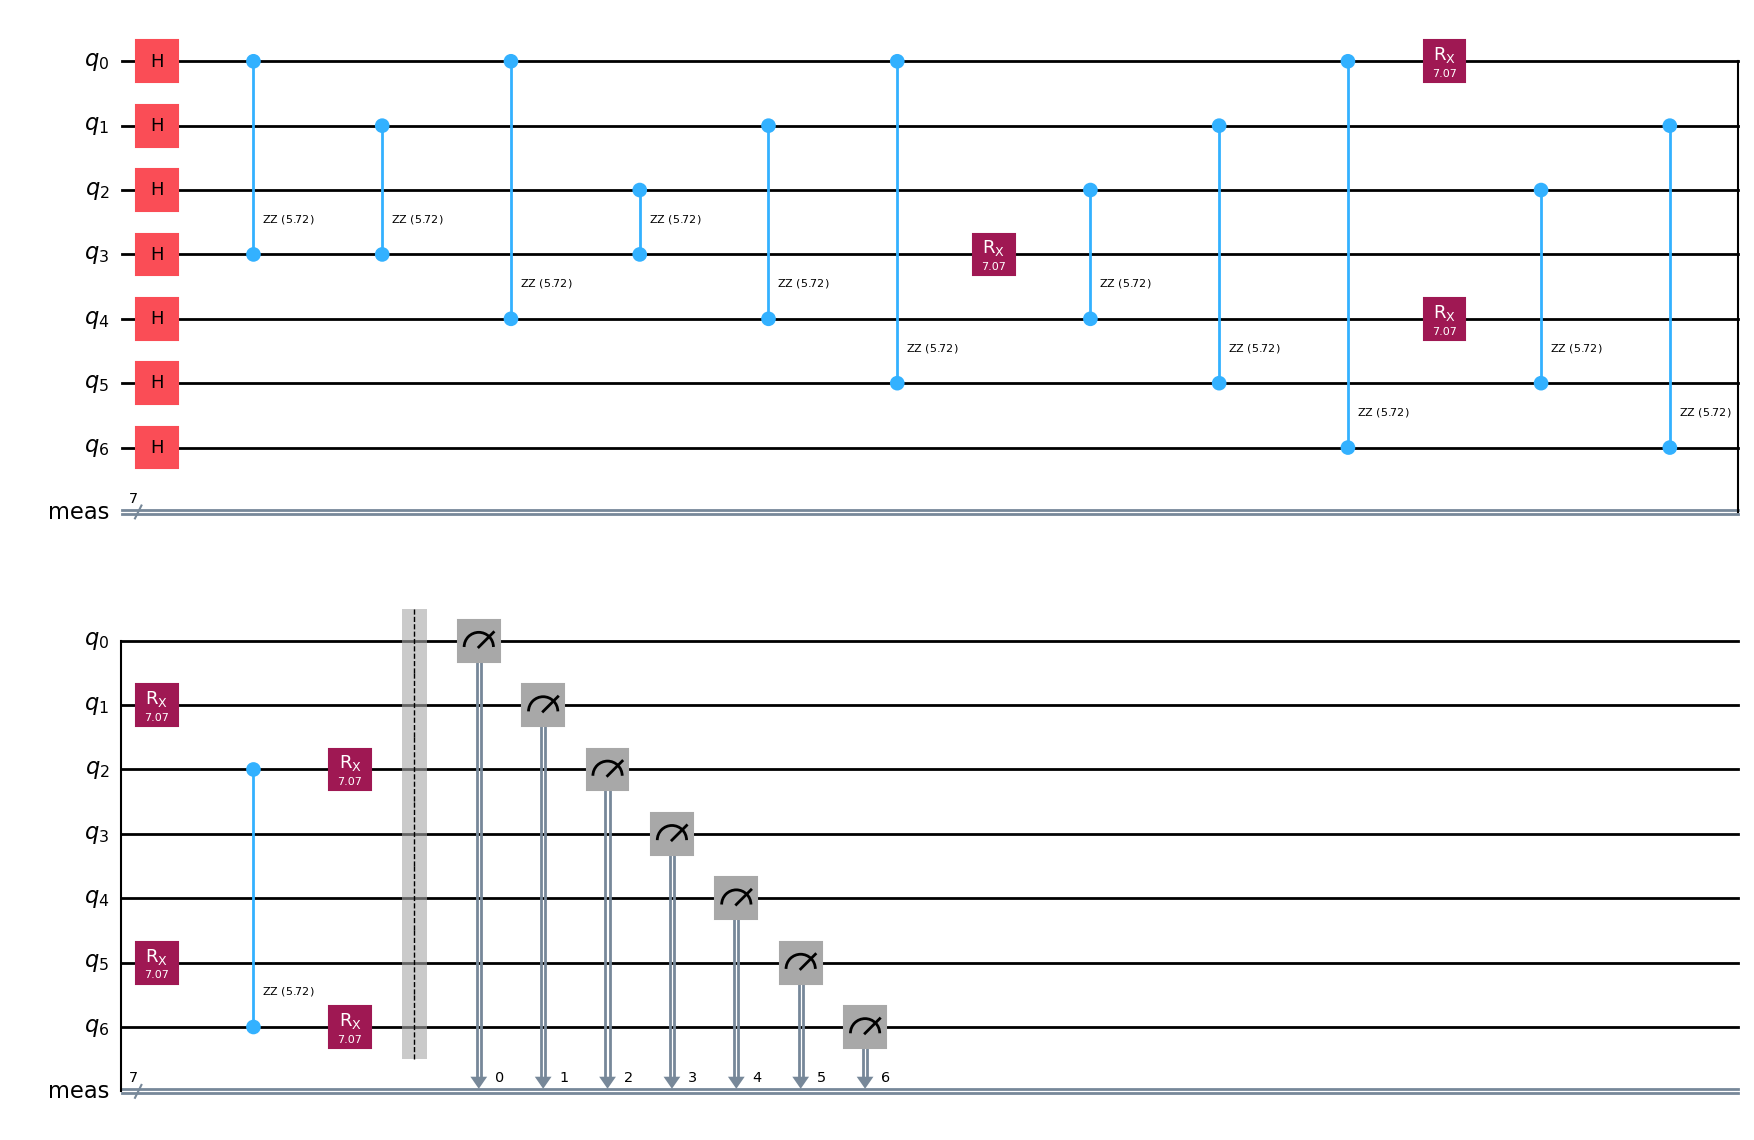

In [164]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

qc = ansatz.assign_parameters(res.x)

qc.measure_all()

pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0)
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl")

In [165]:
result = sampler.run([qc_isa]).result()
samp_dist = result.quasi_dists[0]

In [166]:
def convert_to_binary_states(quasi_dists, num_qubits):
    binary_dists = {}

    for index, probability in quasi_dists.items():
        binary_state = format(index, f'0{num_qubits}b')
        binary_dists[binary_state] = probability

    return binary_dists

stany = convert_to_binary_states(samp_dist, 7)
max_key = max(stany, key=stany.get)
max_prob = stany[max_key]

print(max_prob)
print(max_key)

0.133429892549992
0000111


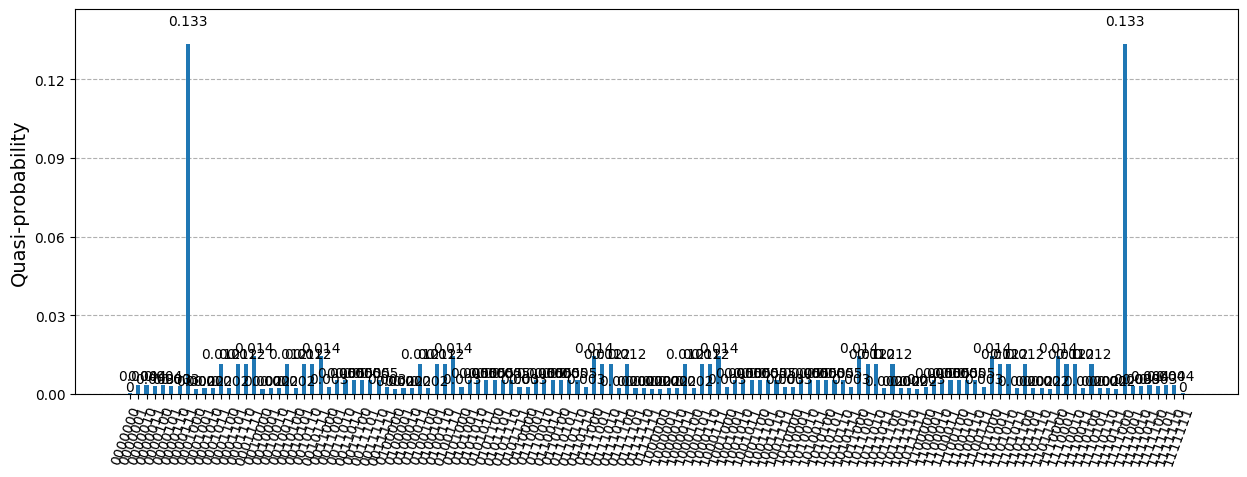

In [167]:
plot_distribution(stany, figsize=(15, 5))


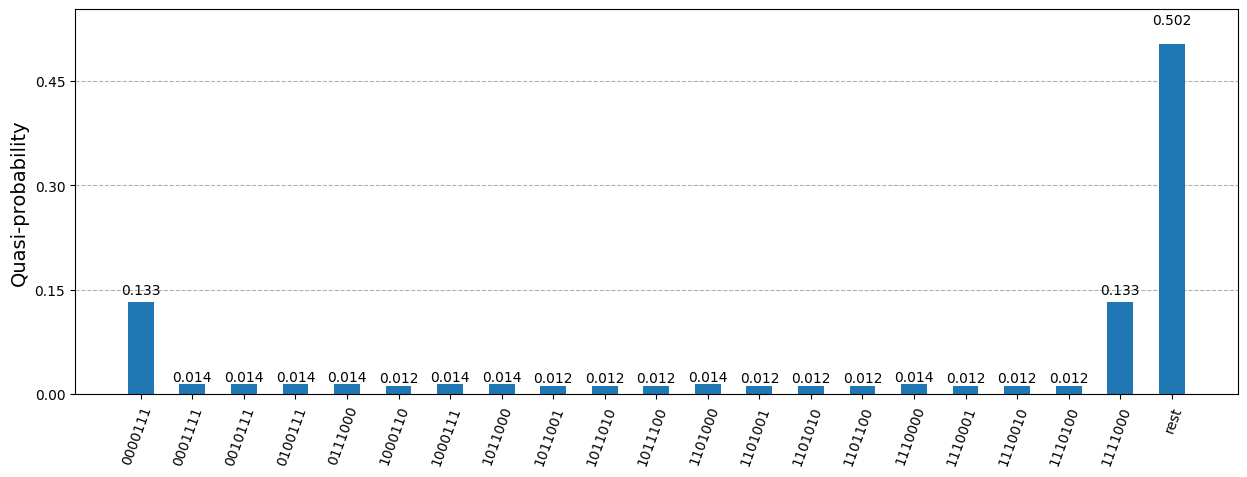

In [168]:
plot_distribution(stany, figsize=(15, 5),  number_to_keep=20)

In [169]:
max_key = max_key[::-1]

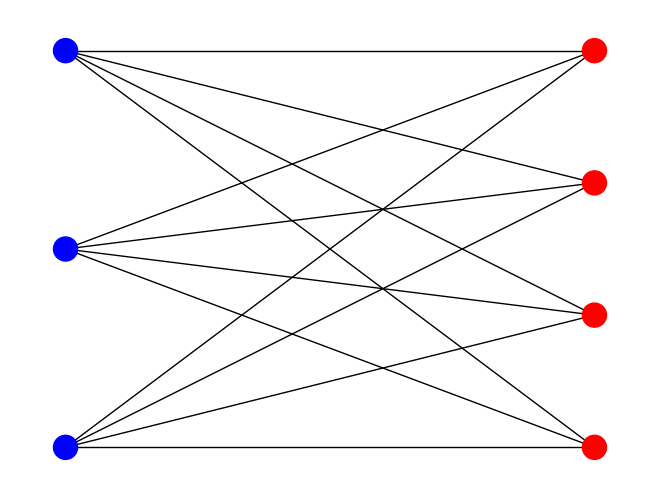

In [170]:
colors = ['r' if max_key[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, gList))